# PIT Summary

# Purpose
There has been a lot done in the parameter identification techniques (PIT) in this project, this notebook is a summary.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

#import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
#import src.models.nonlinear_martin_vmm as vmm
#import src.nonlinear_martin_vmm_equations as eq

#import src.models.linear_vmm as vmm
import src.linear_vmm_equations as eq

#import src.models.linear_vmm as model
from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
Math(vlatex(eq.X_eq))

<IPython.core.display.Math object>

In [3]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

In [4]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [5]:
Math(vlatex(eq.X_eq.rhs-eq.X_eq.lhs))

<IPython.core.display.Math object>

In [6]:
Math(vlatex(eq.Y_eq.rhs-eq.Y_eq.lhs))

<IPython.core.display.Math object>

In [7]:
Math(vlatex(eq.N_eq.rhs-eq.N_eq.lhs))

<IPython.core.display.Math object>

## Load test

In [8]:
#id=22773
#id=22616
id=22774
#id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df['t'] = df.index
df.sort_index(inplace=True)
df['-delta'] = -df['delta']
df['V'] = np.sqrt(df['u']**2 + df['v']**2)

df['thrust'] = df['Prop/PS/Thrust'] + df['Prop/SB/Thrust']
df['U'] = df['V']

In [9]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']

<AxesSubplot:xlabel='time'>

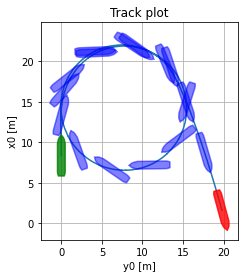

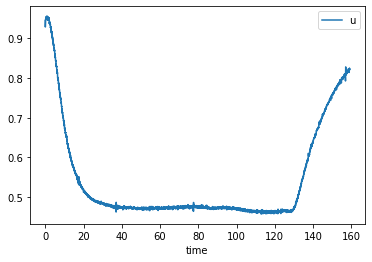

In [10]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);
df.plot(y='u')

# Ship parameters

In [11]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : meta_data.lcg,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
        'volume':meta_data.Volume,
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship
ship_parameters_prime = ps.prime(ship_parameters)

## Prime system

In [12]:
interesting = ['x0','y0','psi','u','v','r','u1d','v1d','r1d','U','t','delta','thrust']
df_prime = ps.prime(df[interesting], U=df['U'])
df_prime.set_index('t', inplace=True)

<AxesSubplot:xlabel='t'>

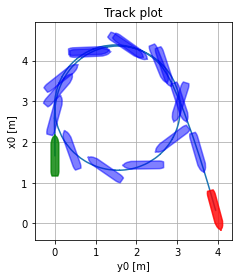

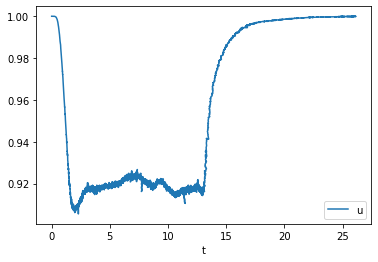

In [13]:
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],
           x_dataset='x0', y_dataset='y0',  psi_dataset='psi', ax=ax);

df_prime.plot(y='u')

In [14]:
df.index

Float64Index([                 0.0, 0.010002000000000066, 0.020001999999999853,
               0.03002200000000066,  0.04000199999999943,  0.05000099999999996,
               0.06000200000000078,   0.0700219999999998,  0.08000099999999932,
                0.0899990000000006,
              ...
                        159.050005,           159.060013,               159.07,
                        159.080005,           159.090005,           159.100006,
                        159.110017,           159.120001,           159.130005,
                        159.140008],
             dtype='float64', name='time', length=15915)

In [15]:
df_prime.index

Float64Index([                  0.0, 0.0018590505176670773,
               0.003703278795339165,  0.005567789136387368,
                0.00743809610775319,  0.009300584387083548,
                0.01116513279812117,   0.01306781836916762,
               0.014973821105671309,  0.016852159385169353,
              ...
                 26.016530241872566,     26.08549683298727,
                 26.155073443087844,     26.15859030345773,
                 26.144083237296872,     26.12877144218778,
                 26.116362811864647,    26.101964884226014,
                  26.08629050013182,    26.075838054271756],
             dtype='float64', name='t', length=15915)

In [16]:
t_ = np.array([0,1,2])
U_ = np.array([1,2,2])
t_prime = ps._prime(t_, unit='time', U=U_)
t_prime

array([0.        , 0.39883833, 0.79767667])

In [17]:
ps._unprime(t_prime, unit='time', U=U_)

array([0., 1., 2.])

# Brix parameters

In [18]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)


mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)

df_parameters.loc['Ydelta','brix_prime'] = 0.0004  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/4  # Just guessing

df_parameters['brix_prime'].fillna(0, inplace=True)
#df_parameters['brix_SI'].fillna(0, inplace=True)



## Simulate with Brix

In [19]:
eqs = [eq.X_eq, eq.Y_eq, eq.N_eq]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

## Decouple the equations:
u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()])

## Lambdify:
subs = {value:key for key,value in eq.p.items()}
u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)

In [20]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, ship_parameters, control):

    u,v,r,x0,y0,psi = states
    states_dict = {
        'u':u,
        'v':v,
        'r':r,
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
    
    inputs = dict(parameters)
    inputs.update(ship_parameters)
    inputs.update(states_dict)
    
    if isinstance(control, pd.DataFrame):
        index = np.argmin(np.array(np.abs(control.index - t)))
        control_ = dict(control.iloc[index])
    else:
        control_ = control
    inputs.update(control_)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    u1d = run(function=u1d_lambda, inputs=inputs)
    v1d = run(function=v1d_lambda, inputs=inputs)
    r1d = run(function=r1d_lambda, inputs=inputs)
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    
    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    return dstates

In [21]:
df_ = df_prime.copy()
t = df_.index
t_span = [t.min(),t.max()]
t_eval = np.linspace(t.min(),t.max(),len(t))

control = df_[['delta','thrust']]

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi']
    }

parameters = df_parameters['brix_prime']

solution = solve_ivp(fun=step, t_span=t_span, y0=list(y0.values()), t_eval=t_eval, 
            args=(parameters, ship_parameters_prime, control))

In [22]:
columns = list(y0.keys())
df_result = pd.DataFrame(data=solution.y.T, columns=columns)
df_result.index=t[0:len(df_result)]

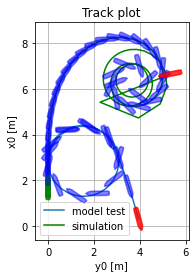

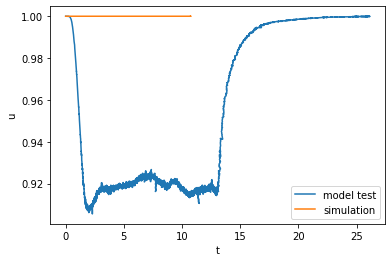

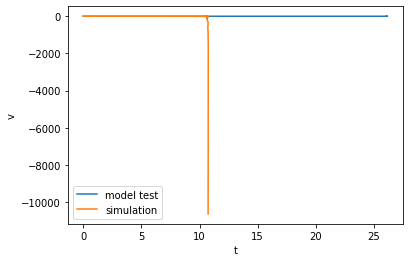

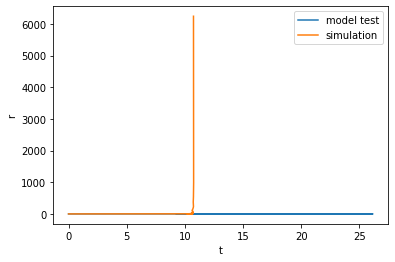

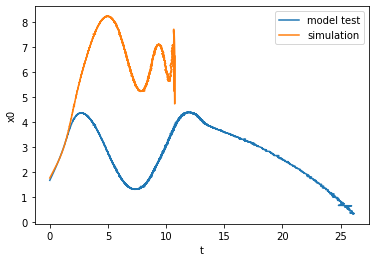

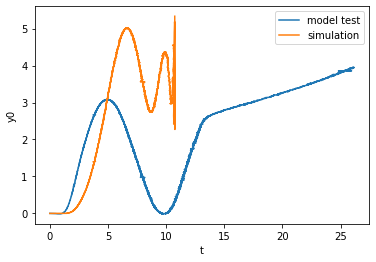

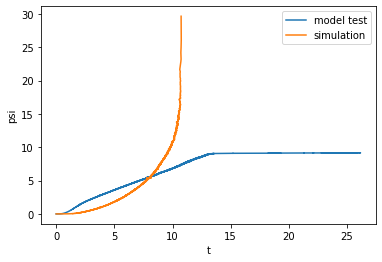

In [23]:
fig,ax=plt.subplots()
track_plot(df=df_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df_prime.plot(y=key, label='model test', ax=ax)
    df_result.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

## Back to SI

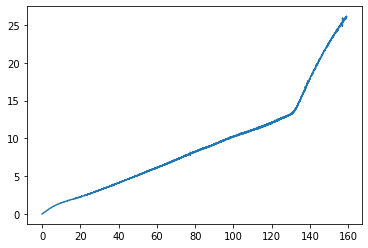

In [24]:
fig,ax=plt.subplots()
ax.plot(df.index,df_prime.index)

In [25]:
U_ = ship_parameters['L']*df_prime.index/df.index
df_unprime = ps.unprime(df_prime, U=U_)
df_unprime.index = ps._unprime(df_prime.index,unit='time',U=U_)

<AxesSubplot:xlabel='time'>

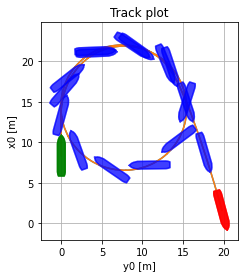

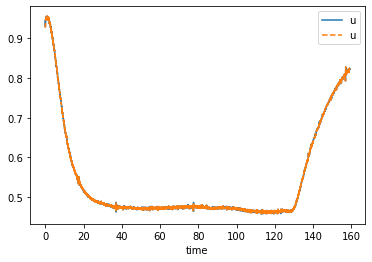

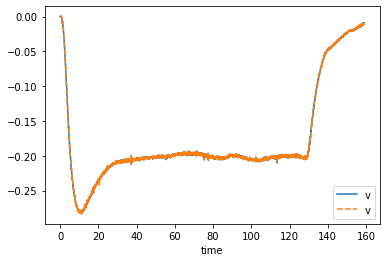

In [26]:
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);
track_plot(df=df_unprime, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

fig,ax=plt.subplots()
df.plot(y='u',ax=ax)
df_unprime.plot(y='u', style='--', ax=ax)

fig,ax=plt.subplots()
df.plot(y='v',ax=ax)
df_unprime.plot(y='v', style='--', ax=ax)

# VCT regression

## Load VCT data

In [27]:
df_VCT_all = pd.read_csv('../data/external/vct.csv', index_col=0)
df_VCT_all.head()

,level_0,Dp,S,S_Xgrid,S_inner_bracket_port,S_inner_bracket_stb,S_outer_bracket_port,S_outer_bracket_stb,S_rudder_port,S_rudder_stb,S_shaft_port_assembly,S_shaft_port_shaft1,S_shaft_port_shaft2,S_shaft_stb_assembly,S_shaft_stb_shaft1,S_shaft_stb_shaft2,V,beta,delta,fx,fx_Xgrid,fx_inner_bracket_port,fx_inner_bracket_stb,fx_outer_bracket_port,fx_outer_bracket_stb,fx_rudder_port,fx_rudder_stb,fx_shaft_port_assembly,fx_shaft_port_shaft1,fx_shaft_port_shaft2,fx_shaft_stb_assembly,fx_shaft_stb_shaft1,fx_shaft_stb_shaft2,fy,fy_Xgrid,fy_inner_bracket_port,fy_inner_bracket_stb,fy_outer_bracket_port,fy_outer_bracket_stb,fy_rudder_port,fy_rudder_stb,fy_shaft_port_assembly,fy_shaft_port_shaft1,fy_shaft_port_shaft2,fy_shaft_stb_assembly,fy_shaft_stb_shaft1,fy_shaft_stb_shaft2,fz,fz_Xgrid,fz_inner_bracket_port,fz_inner_bracket_stb,fz_outer_bracket_port,fz_outer_bracket_stb,fz_rudder_port,fz_rudder_stb,fz_shaft_port_assembly,fz_shaft_port_shaft1,fz_shaft_port_shaft2,fz_shaft_stb_assembly,fz_shaft_stb_shaft1,fz_shaft_stb_shaft2,g,lpp,mx,mx_Xgrid,mx_inner_bracket_port,mx_inner_bracket_stb,mx_outer_bracket_port,mx_outer_bracket_stb,mx_rudder_port,mx_rudder_stb,mx_shaft_port_assembly,mx_shaft_port_shaft1,mx_shaft_port_shaft2,mx_shaft_stb_assembly,mx_shaft_stb_shaft1,mx_shaft_stb_shaft2,my,my_Xgrid,my_inner_bracket_port,my_inner_bracket_stb,my_outer_bracket_port,my_outer_bracket_stb,my_rudder_port,my_rudder_stb,my_shaft_port_assembly,my_shaft_port_shaft1,my_shaft_port_shaft2,my_shaft_stb_assembly,my_shaft_stb_shaft1,my_shaft_stb_shaft2,mz,mz_Xgrid,mz_inner_bracket_port,mz_inner_bracket_stb,mz_outer_bracket_port,mz_outer_bracket_stb,mz_rudder_port,mz_rudder_stb,mz_shaft_port_assembly,mz_shaft_port_shaft1,mz_shaft_port_shaft2,mz_shaft_stb_assembly,mz_shaft_stb_shaft1,mz_shaft_stb_shaft2,r,result_file_path,rho,u,v,name,path,thrust,rev,p,phi,model_name,S_BK_port1,S_BK_stb1,fx_BK_port1,fx_BK_stb1,fy_BK_port1,fy_BK_stb1,fz_BK_port1,fz_BK_stb1,mx_BK_port1,mx_BK_stb1,my_BK_port1,my_BK_stb1,mz_BK_port1,mz_BK_stb1,S_daggerboard_middle,fx_daggerboard_middle,fy_daggerboard_middle,fz_daggerboard_middle,mx_daggerboard_middle,my_daggerboard_middle,mz_daggerboard_middle,S_R4083_ref,fx_R4083_ref,fy_R4083_ref,fz_R4083_ref,mx_R4083_ref,my_R4083_ref,mz_R4083_ref,S_Rudder_Center,S_Rudder_Port,S_Rudder_Starboard,S_hull,S_rudder,fx_Rudder_Center,fx_Rudder_Port,fx_Rudder_Starboard,fx_hull,fx_rudder,fy_Rudder_Center,fy_Rudder_Port,fy_Rudder_Starboard,fy_hull,fy_rudder,fz_Rudder_Center,fz_Rudder_Port,fz_Rudder_Starboard,fz_hull,fz_rudder,mx_Rudder_Center,mx_Rudder_Port,mx_Rudder_Starboard,mx_hull,mx_rudder,my_Rudder_Center,my_Rudder_Port,my_Rudder_Starboard,my_hull,my_rudder,mz_Rudder_Center,mz_Rudder_Port,mz_Rudder_Starboard,mz_hull,mz_rudder,torque,test type,eta0,eta0_round,fx_rudders,fy_rudders,fz_rudders,mx_rudders,my_rudders,mz_rudders,clr,S_daggerboard_port,S_daggerboard_stb,fake_index,fx_daggerboard_port,fx_daggerboard_stb,fy_daggerboard_port,fy_daggerboard_stb,fz_daggerboard_port,fz_daggerboard_stb,mx_daggerboard_port,mx_daggerboard_stb,my_daggerboard_port,my_daggerboard_stb,mz_daggerboard_port,mz_daggerboard_stb,$\frac{fx}{V^2}$,$\frac{fy}{V^2}$,$\frac{mz}{V^2}$
0,165,7.3,7375.872,7277.256591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173333,0.0,-0.000000,-261193.992917,-252076.078409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1308.975604,-295.088406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.879028e+06,-5.881622e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.80665,196.0,5.778834e+02,-1085.233044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.173220e+08,6.178902e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.236840e+05,2.386122e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,1025.0,6.173333,-0.0,12knotsResistance,L:\proj2019\40199079-Segelfartyg-Wallenius\VCT...,0.0,0.0,0,0,HERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.61946

In [28]:
df_VCT = df_VCT_all.groupby(by=['model_name']).get_group('V2_5_MDL_modelScale')

# Subtract the resistance

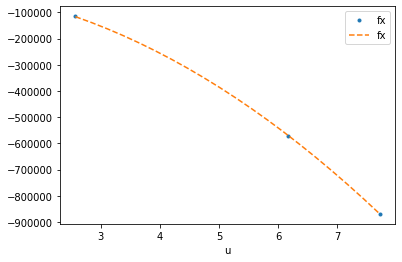

In [29]:
df_resistance = df_VCT.groupby(by='test type').get_group('resistance')

X = df_resistance[['u','fx']].copy()
X['u**2'] = X['u']**2
y = X.pop('fx')

model_resistance = sm.OLS(y,X)
results_resistance = model_resistance.fit()

X_pred = pd.DataFrame()
X_pred['u'] = np.linspace(X['u'].min(), X['u'].max(), 20)
X_pred['u**2'] = X_pred['u']**2
X_pred['fx'] = results_resistance.predict(X_pred)

fig,ax=plt.subplots()
df_resistance.plot(x='u', y='fx', style='.', ax=ax)
X_pred.plot(x='u', y='fx', style='--', ax=ax);


In [30]:
df_VCT_0_resistance = df_VCT.copy()
df_VCT_0_resistance['u**2'] = df_VCT_0_resistance['u']**2
df_VCT_0_resistance['fx']-= results_resistance.predict(df_VCT_0_resistance[['u','u**2']])

## VCT to prime system

In [31]:
interesting = [
    'u',
    'v',
    'r',
    'delta',
    'fx',
    'fy',
    'mz',
    'thrust',
]
df_VCT_prime = ps_ship.prime(df_VCT_0_resistance[interesting], U=df_VCT_0_resistance['V'])

In [32]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred_vct(X,y,results, label):
    
    display(results.summary())
    
    X_ = X.copy()
    X_['y'] = y
    X_.sort_values(by='y', inplace=True)
        
    y_ = X_.pop('y')
    
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    #ax.plot(X_.index,y_, label='Numerical gradient from model test')
    #ax.plot(X_.index,y_pred, '--', label='OLS')
    
    ax.plot(y_,y_pred, '.')
    ax.plot([y_.min(),y_.max()], [y_.min(),y_.max()], 'r-')
    
    ax.set_ylabel(f'{label} (prediction)')    
    ax.set_xlabel(label)
    
    ax.fill_between(y_, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5% confidence')
    ax.legend();

## N

In [87]:
eq.N_qs_eq

Eq(N_qs(u(t), v(t), r(t), delta(t)), N_{delta}*delta(t) + N_{r}*r(t) + N_{u}*u(t) + N_{v}*v(t))

In [88]:
label = sp.symbols('N_qs')
N_eq = eq.N_qs_eq.subs(N_qs,label)
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=label, base_features=[delta,u,v,r])

In [89]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1051.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                    1.89e-33
Time:                        18:09:37   Log-Likelihood:                          310.40
No. Observations:                  36   AIC:                                     -612.8
Df Residuals:                      32   BIC:                                     -606.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0026      0.000    -26.455      0.000      -0.003      -0.002
Nr            -0.0026   5.86e-05    -45.023      0.000      -0.003      -0.003
Nu         -4.849e-05    1.4e-05     -3.460      0.002    -7.7e-05   -1.99e-05
Nv            -0.0020      0.000    -12.675      0.000      -0.002      -0.002
==============================================================================
Omnibus:                        4.736   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                3.474
Skew:                           0.499   Prob(JB):                        0.176
Kurtosis:                       4.149   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

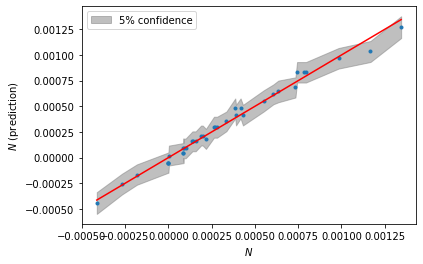

In [90]:
X = diff_eq_N.calculate_features(data=df_VCT_prime)
y = diff_eq_N.calculate_label(y=df_VCT_prime['mz'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred_vct(X=X,y=y,results=results_N, label=r'$N$')

## Y

In [91]:
eq.Y_qs_eq

Eq(Y_qs(u(t), v(t), r(t), delta(t)), Y_{delta}*delta(t) + Y_{r}*r(t) + Y_{u}*u(t) + Y_{v}*v(t))

In [92]:
label = sp.symbols('Y_qs')
Y_eq = eq.Y_qs_eq.subs(Y_qs,label)
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=label, base_features=[delta,u,v,r])

In [93]:
Math(vlatex(diff_eq_Y.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1185.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                    2.83e-34
Time:                        18:09:38   Log-Likelihood:                          282.55
No. Observations:                  36   AIC:                                     -557.1
Df Residuals:                      32   BIC:                                     -550.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0044      0.000     20.359      0.000       0.004       0.005
Yr             0.0024      0.000     18.545      0.000       0.002       0.003
Yu            -0.0001   3.04e-05     -3.563      0.001      -0.000   -4.64e-05
Yv            -0.0133      0.000    -39.314      0.000      -0.014      -0.013
==============================================================================
Omnibus:                        4.535   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                1.772
Skew:                          -0.053   Prob(JB):                        0.412
Kurtosis:                       1.918   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

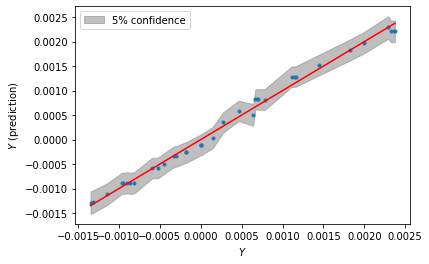

In [94]:
X = diff_eq_Y.calculate_features(data=df_VCT_prime)
y = diff_eq_Y.calculate_label(y=df_VCT_prime['fy'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred_vct(X=X,y=y,results=results_Y, label=r'$Y$')

## X

In [95]:
eq.X_qs_eq

Eq(X_qs(u(t), v(t), r(t), delta(t)), X_{delta}*delta(t) + X_{r}*r(t) + X_{u}*u(t) + X_{v}*v(t))

In [96]:
label = sp.symbols('X_qs')
X_eq = eq.X_qs_eq.subs(X_qs,label)
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=label, base_features=[delta,u,v,r])

In [97]:
Math(vlatex(diff_eq_X.acceleration_equation))

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.302
Model:                            OLS   Adj. R-squared (uncentered):              0.215
Method:                 Least Squares   F-statistic:                              3.463
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                      0.0185
Time:                        18:09:38   Log-Likelihood:                          302.18
No. Observations:                  36   AIC:                                     -596.4
Df Residuals:                      32   BIC:                                     -590.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta      6.376e-05      0.000      0.507      0.616      -0.000       0.000
Xr         -3.527e-05   7.37e-05     -0.479      0.635      -0.000       0.000
Xu          -2.46e-05   1.76e-05     -1.397      0.172   -6.05e-05    1.13e-05
Xv             0.0002      0.000      1.101      0.279      -0.000       0.001
==============================================================================
Omnibus:                       21.003   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.150
Skew:                          -1.669   Prob(JB):                     4.68e-07
Kurtosis:                       5.879   Cond. No.                         21.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

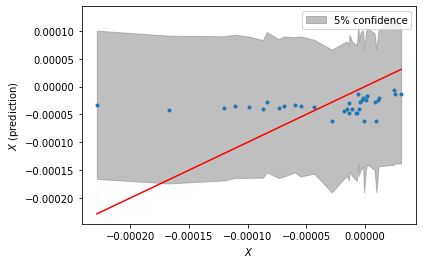

In [98]:
X = diff_eq_X.calculate_features(data=df_VCT_prime)
y = diff_eq_X.calculate_label(y=df_VCT_prime['fx'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred_vct(X=X,y=y,results=results_X, label=r'$X$')

In [99]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [100]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['prime'] = df_parameters_all['regressed'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

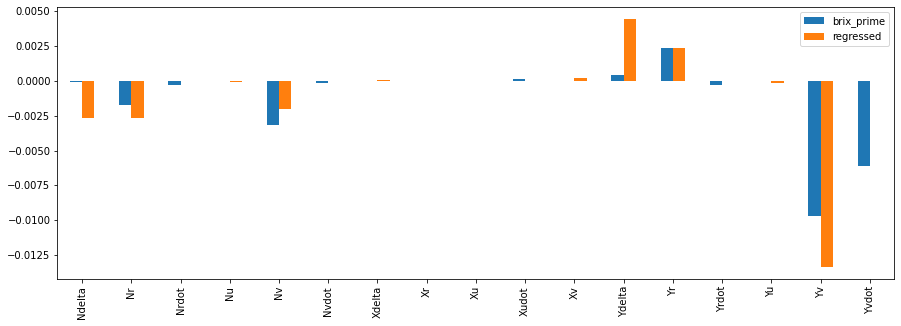

In [101]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)

mask = ((df_parameters_all['brix_prime']!=0) |
        (pd.notnull(df_parameters_all['regressed'])))
                
df_parameters_all_plot = df_parameters_all.loc[mask]
df_parameters_all_plot.plot.bar(y=['brix_prime','regressed'], ax=ax);

## Simulate

In [102]:
df_ = df_prime.copy()
t = df_.index
t_span = [t.min(),t.max()]
t_eval = np.linspace(t.min(),t.max(),len(t))

control = df_[['delta','thrust']]

df_0 = df_.iloc[0:100].median(axis=0)
y0 = {
    'u' : df_0['u'], 
    'v' : df_0['v'],
    'r' : df_0['r'],
    'x0' : df_0['x0'],
    'y0' : df_0['y0'],
    'psi' : df_0['psi']
    }

parameters = df_parameters_all['prime'].copy()  # Change!!

solution = solve_ivp(fun=step, t_span=t_span, y0=list(y0.values()), t_eval=t_eval, 
            args=(parameters, ship_parameters_prime, control))

columns = list(y0.keys())
df_result_VCT = pd.DataFrame(data=solution.y.T, columns=columns)
df_result_VCT.index=t[0:len(df_result_VCT)]

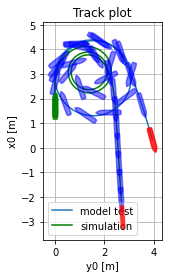

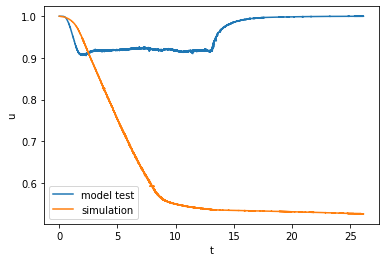

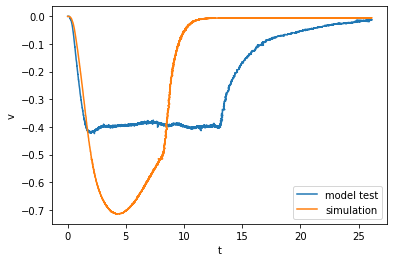

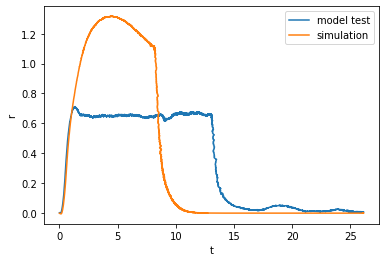

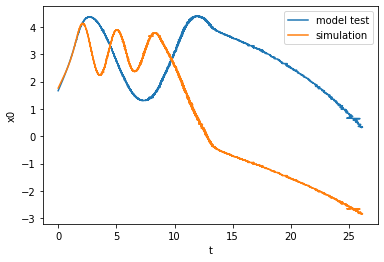

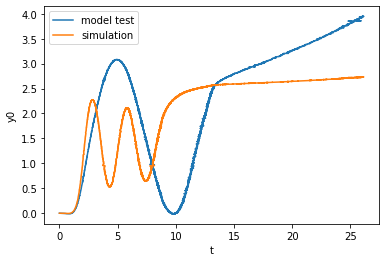

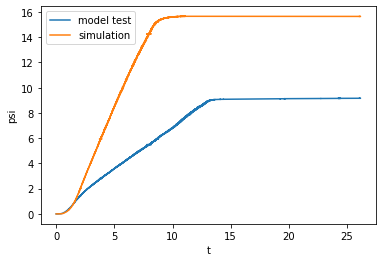

In [103]:
fig,ax=plt.subplots()
track_plot(df=df_prime, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='model test')
track_plot(df=df_result_VCT, lpp=ship_parameters_prime['L'], beam=ship_parameters_prime['B'],ax=ax, label='simulation', color='green')
ax.legend()


for key in df_result:
    fig,ax = plt.subplots()
    df_prime.plot(y=key, label='model test', ax=ax)
    df_result_VCT.plot(y=key, label='simulation', ax=ax)
    ax.set_ylabel(key)

# Time series PIT

In [104]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

## N

In [105]:
N_eq = eq.N_eq.copy()
N_eq = N_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    #(eq.p.Nvdot,0),  # Removing added mass
    #(eq.p.Nudot,0),  # Removing added mass
    
])  

solution = sp.solve(N_eq,r.diff())[0]
inertia_ = (I_z-eq.p.Nrdot)
N_eq = sp.Eq(r.diff()*inertia_, solution*inertia_)


In [106]:
Math(vlatex(N_eq))

<IPython.core.display.Math object>

In [107]:
label_N = N_eq.lhs
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=label_N, base_features=[delta,u,v,r])

In [108]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

In [109]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [110]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [111]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\dot{u}}],
[N_{\dot{v}}],
[  N_{delta}],
[      N_{r}],
[      N_{u}],
[      N_{v}]]))

In [112]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [113]:
diff_eq_N.y_lambda

<function _lambdifygenerated(I_z, Nrdot, r1d)>

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.930
Method:                 Least Squares   F-statistic:                          3.497e+04
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                        0.00
Time:                        18:09:44   Log-Likelihood:                      1.3744e+05
No. Observations:               15915   AIC:                                 -2.749e+05
Df Residuals:                   15909   BIC:                                 -2.748e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nudot      -1.591e-05   6.52e-06     -2.440      0.015   -2.87e-05   -3.13e-06
Nvdot         -0.0027    1.8e-05   -147.826      0.000      -0.003      -0.003
Ndelta        -0.0012   1.26e-05    -97.969      0.000      -0.001      -0.001
Nr            -0.0009    1.5e-05    -57.491      0.000      -0.001      -0.001
Nu         -6.329e-06    9.9e-07     -6.390      0.000   -8.27e-06   -4.39e-06
Nv            -0.0036   3.97e-05    -90.192      0.000      -0.004      -0.004
==============================================================================
Omnibus:                     4979.308   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25781.193
Skew:                          -1.419   Prob(JB):                         0.00
Kurtosis:                       8.552   Cond. No.                         176.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

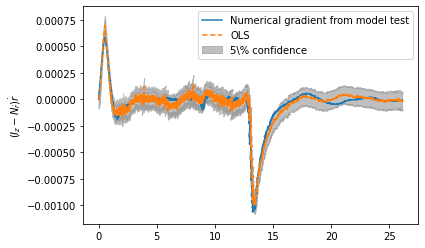

In [114]:
X = diff_eq_N.calculate_features(data=df_prime)
y = run(function=diff_eq_N.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$%s$' % vlatex(label_N))

## Y

In [115]:
Y_eq = eq.Y_eq.copy()
Y_eq = Y_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    #(eq.p.Nvdot,0),  # Removing added mass
    #(eq.p.Nudot,0),  # Removing added mass
    
])  

solution = sp.solve(Y_eq,v.diff())[0]
inertia_ = (eq.p.Yvdot-m)
Y_eq = sp.simplify(sp.Eq(v.diff()*inertia_-U*m*r, solution*inertia_-U*m*r))

Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [116]:
label_Y = Y_eq.lhs
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=label_Y, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.292e+07
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                        0.00
Time:                        18:09:45   Log-Likelihood:                      1.1645e+05
No. Observations:               15915   AIC:                                 -2.329e+05
Df Residuals:                   15909   BIC:                                 -2.328e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yrdot         -0.0021   1.42e-05   -147.826      0.000      -0.002      -0.002
Yudot         -0.0008   2.36e-05    -33.157      0.000      -0.001      -0.001
Ydelta        -0.0008   5.93e-05    -13.607      0.000      -0.001      -0.001
Yr             0.0059   6.09e-05     97.436      0.000       0.006       0.006
Yu            -0.0001   3.61e-06    -28.891      0.000      -0.000   -9.73e-05
Yv            -0.0212   7.12e-05   -297.562      0.000      -0.021      -0.021
==============================================================================
Omnibus:                      256.701   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.018
Skew:                           0.303   Prob(JB):                     7.70e-58
Kurtosis:                       2.826   Cond. No.                         83.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

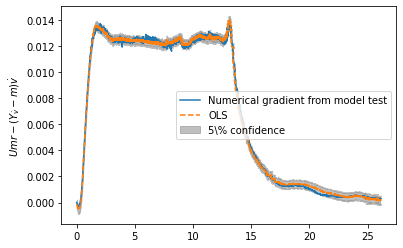

In [117]:
X = diff_eq_Y.calculate_features(data=df_prime)
y = run(function=diff_eq_Y.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$%s$' % vlatex(label_Y))

## X

In [118]:
X_eq = eq.X_eq.copy()
X_eq = X_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    #(eq.p.Nvdot,0),  # Removing added mass
    #(eq.p.Nudot,0),  # Removing added mass
    
])  

solution = sp.solve(X_eq,u.diff())[0]
inertia_ = m-eq.p.Xudot
X_eq = sp.simplify(sp.Eq(v.diff()*inertia_, solution*inertia_))

Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [119]:
label_X = X_eq.lhs
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=label_X, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.562e+31
Date:                Thu, 08 Jul 2021   Prob (F-statistic):                        0.00
Time:                        18:09:47   Log-Likelihood:                      5.8378e+05
No. Observations:               15915   AIC:                                 -1.168e+06
Df Residuals:                   15909   BIC:                                 -1.167e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xrdot      -3.343e-18   3.85e-18     -0.867      0.386   -1.09e-17    4.21e-18
Xvdot          0.0068   1.78e-17   3.84e+14      0.000       0.007       0.007
Xdelta      6.272e-18   1.04e-17      0.605      0.545   -1.41e-17    2.66e-17
Xr          6.395e-18   1.05e-17      0.608      0.543   -1.42e-17     2.7e-17
Xu          9.186e-19   6.54e-19      1.404      0.160   -3.64e-19     2.2e-18
Xv         -1.013e-16   2.74e-17     -3.692      0.000   -1.55e-16   -4.75e-17
==============================================================================
Omnibus:                     3596.987   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6591.966
Skew:                           1.546   Prob(JB):                         0.00
Kurtosis:                       3.614   Cond. No.                         196.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

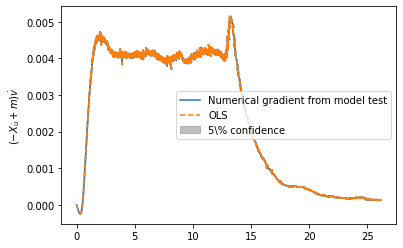

In [120]:
X = diff_eq_X.calculate_features(data=df_prime)
y = run(function=diff_eq_X.y_lambda, inputs=df_prime, **ship_parameters_prime, **df_parameters_all['brix_prime'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$%s$' % vlatex(label_X))

In [121]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Add regressed parameters

In [130]:
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'coeff':'PIT'}, inplace=True)

#df_parameters_all['prime'] = df_parameters_all['PIT'].combine_first(df_parameters_all['brix_prime'])  # prefer regressed

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(15,5)

mask = ((df_parameters_all['brix_prime']!=0) |
        (pd.notnull(df_parameters_all['regressed'])) |
        (pd.notnull(df_parameters_all['PIT'])))
                
df_parameters_all_plot = df_parameters_all.loc[mask]
df_parameters_all_plot.plot.bar(y=['brix_prime','regressed','PIT'], ax=ax);